# Estimate covariance matrix of financial time series (FTS)

In [1]:
import re
import sys
import warnings
import numpy as np # type: ignore
import pandas as pd # type: ignore

sys.path.append('../modules')
import misc_functions as mf # type: ignore
import estimate_entropy as ee # type: ignore
import estimate_market_factors as emf # type: ignore
import get_financial_time_series as get_fts # type: ignore

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
#pd.options.display.max_rows = 277

## Global variables

In [2]:
input_path_raw = "../input_files/raw_data"
input_path_processed = "../input_files/processed_data"
input_path_data_dictionary = "../input_files/data_dictionary"
log_path = "../logs"
output_path = "../output_files"
input_generation_date = "2024-07-24"
stock_index_name = "gdaxi"

time_delta = 240
time_step = 20

## Load data and filter duplicates by symbol and date

In [3]:
# Load data and filter duplicates by symbol and date
df_stock_index = pd.read_pickle(
    "{}/df_stock_index_{}_{}.pkl".format(
        input_path_processed,
        stock_index_name,
        re.sub("-", "", input_generation_date)
    )
)

df_stock_index.drop_duplicates(subset = ["date", "symbol"], keep = "first", inplace = True, ignore_index = True)

## Rolling window analysis

In [4]:
market_args_list = df_stock_index[["date"]].sort_values(by = ["date"]).value_counts(sort = False).reset_index()
market_args_list["final_date"] = market_args_list["date"] + pd.DateOffset(days = time_delta)
market_args_list = (
    market_args_list
        .rename(columns = {"date" : "initial_date"})
        .iloc[::time_step]
        .reset_index()
        .drop(columns = ["count", "index"])
)
market_args_list["initial_date"] = market_args_list["initial_date"].astype(str)
market_args_list["final_date"] = market_args_list["final_date"].astype(str)
market_args_list#.values.tolist()


,initial_date,final_date
0,2000-01-04,2000-08-31
1,2000-02-01,2000-09-28
2,2000-02-29,2000-10-26
3,2000-03-28,2000-11-23
4,2000-04-27,2000-12-23
...,...,...
307,2024-03-06,2024-11-01
308,2024-04-05,2024-12-01
309,2024-05-06,2025-01-01
310,2024-06-03,2025-01-29


In [5]:
# Normalized Returns
df_final_3 = []
for k in range(market_args_list.shape[0]):
    initial_date = market_args_list["initial_date"].values[k]
    final_date = market_args_list["final_date"].values[k]
    try:
        df_aux = emf.get_market_efficiency(
            df = df_stock_index,
            column_ = "z_score_log_return",
            min_bins = 10,
            precision = 12,
            log_path = log_path,
            log_filename = "log_rolling_window_{}".format(stock_index_name),
            log_filename_entropy = "log_entropy_rolling_{}".format(stock_index_name),
            verbose = 1,
            tqdm_bar = True,
            market_args_list = (initial_date, final_date),
            bouchaud_filter = False,
            n = int(df_stock_index.shape[0] * 2),
            df_tracy_widom = pd.read_csv("{}/tracy_widom.csv".format(input_path_data_dictionary), low_memory = False),
            alphas = [0.01, 0.05, 0.10],
            k_max = 8,
            df_onatski = pd.read_csv("{}/onatski.csv".format(input_path_data_dictionary), low_memory = False),
            levels = [1, 2, 5, 10]
        )

        df_final_3.append(df_aux)

        print("Finished: {} - {}".format(initial_date, final_date))
    except:
        print("No done: {} - {}".format(initial_date, final_date))

df_final_3 = pd.concat(df_final_3)

100%|████████████████████| 378/378 [00:02<00:00, 170.81it/s]


Finished: 2000-01-04 - 2000-08-31


100%|████████████████████| 378/378 [00:02<00:00, 159.32it/s]


Finished: 2000-02-01 - 2000-09-28


100%|████████████████████| 378/378 [00:02<00:00, 178.56it/s]


Finished: 2000-02-29 - 2000-10-26


100%|████████████████████| 378/378 [00:02<00:00, 171.07it/s]


Finished: 2000-03-28 - 2000-11-23


100%|████████████████████| 406/406 [00:02<00:00, 183.77it/s]


Finished: 2000-04-27 - 2000-12-23


100%|████████████████████| 406/406 [00:02<00:00, 135.45it/s]


Finished: 2000-05-26 - 2001-01-21


100%|█████████████████████| 406/406 [00:05<00:00, 70.71it/s]


Finished: 2000-06-23 - 2001-02-18


100%|█████████████████████| 406/406 [00:05<00:00, 80.21it/s]


Finished: 2000-07-21 - 2001-03-18


100%|█████████████████████| 435/435 [00:04<00:00, 89.24it/s]


Finished: 2000-08-18 - 2001-04-15


100%|█████████████████████| 465/465 [00:05<00:00, 83.26it/s]


Finished: 2000-09-15 - 2001-05-13


100%|█████████████████████| 465/465 [00:05<00:00, 89.21it/s]


Finished: 2000-10-16 - 2001-06-13


100%|█████████████████████| 496/496 [00:04<00:00, 99.21it/s]


Finished: 2000-11-13 - 2001-07-11


100%|█████████████████████| 496/496 [00:05<00:00, 99.10it/s]


Finished: 2000-12-11 - 2001-08-08


100%|█████████████████████| 496/496 [00:04<00:00, 99.35it/s]


Finished: 2001-01-11 - 2001-09-08


100%|█████████████████████| 496/496 [00:05<00:00, 99.18it/s]


Finished: 2001-02-08 - 2001-10-06


100%|█████████████████████| 496/496 [00:05<00:00, 98.99it/s]


Finished: 2001-03-08 - 2001-11-03


100%|█████████████████████| 496/496 [00:04<00:00, 99.32it/s]


Finished: 2001-04-05 - 2001-12-01


100%|████████████████████| 496/496 [00:04<00:00, 100.83it/s]


Finished: 2001-05-08 - 2002-01-03


100%|█████████████████████| 496/496 [00:05<00:00, 98.30it/s]


Finished: 2001-06-05 - 2002-01-31


100%|█████████████████████| 496/496 [00:05<00:00, 98.68it/s]


Finished: 2001-07-03 - 2002-02-28


100%|█████████████████████| 496/496 [00:05<00:00, 89.49it/s]


Finished: 2001-07-31 - 2002-03-28


100%|█████████████████████| 496/496 [00:06<00:00, 78.64it/s]


Finished: 2001-08-28 - 2002-04-25


100%|█████████████████████| 496/496 [00:05<00:00, 85.97it/s]


Finished: 2001-09-25 - 2002-05-23


100%|█████████████████████| 496/496 [00:05<00:00, 88.39it/s]


Finished: 2001-10-23 - 2002-06-20


100%|████████████████████| 496/496 [00:04<00:00, 100.99it/s]


Finished: 2001-11-20 - 2002-07-18


100%|█████████████████████| 496/496 [00:04<00:00, 99.70it/s]


Finished: 2001-12-18 - 2002-08-15


100%|█████████████████████| 496/496 [00:05<00:00, 97.49it/s]


Finished: 2002-01-22 - 2002-09-19


100%|████████████████████| 496/496 [00:04<00:00, 101.79it/s]


Finished: 2002-02-19 - 2002-10-17


100%|█████████████████████| 496/496 [00:05<00:00, 89.70it/s]


Finished: 2002-03-19 - 2002-11-14


100%|████████████████████| 496/496 [00:04<00:00, 100.13it/s]


Finished: 2002-04-18 - 2002-12-14


100%|████████████████████| 496/496 [00:04<00:00, 100.70it/s]


Finished: 2002-05-17 - 2003-01-12


100%|█████████████████████| 496/496 [00:05<00:00, 98.90it/s]


Finished: 2002-06-14 - 2003-02-09


100%|████████████████████| 496/496 [00:04<00:00, 100.42it/s]


Finished: 2002-07-12 - 2003-03-09


100%|████████████████████| 496/496 [00:04<00:00, 105.03it/s]


Finished: 2002-08-09 - 2003-04-06


100%|████████████████████| 465/465 [00:04<00:00, 102.49it/s]


Finished: 2002-09-06 - 2003-05-04


100%|████████████████████| 465/465 [00:04<00:00, 101.42it/s]


Finished: 2002-10-04 - 2003-06-01


100%|████████████████████| 465/465 [00:04<00:00, 102.89it/s]


Finished: 2002-11-01 - 2003-06-29


100%|█████████████████████| 465/465 [00:05<00:00, 87.84it/s]


Finished: 2002-11-29 - 2003-07-27


100%|█████████████████████| 465/465 [00:05<00:00, 80.96it/s]


Finished: 2003-01-02 - 2003-08-30


100%|█████████████████████| 465/465 [00:05<00:00, 86.67it/s]


Finished: 2003-01-30 - 2003-09-27


100%|█████████████████████| 465/465 [00:04<00:00, 98.46it/s]


Finished: 2003-02-27 - 2003-10-25


100%|█████████████████████| 465/465 [00:04<00:00, 99.57it/s]


Finished: 2003-03-27 - 2003-11-22


100%|█████████████████████| 465/465 [00:04<00:00, 95.80it/s]


Finished: 2003-04-28 - 2003-12-24


100%|█████████████████████| 496/496 [00:05<00:00, 97.37it/s]


Finished: 2003-05-27 - 2004-01-22


100%|████████████████████| 496/496 [00:04<00:00, 103.40it/s]


Finished: 2003-06-24 - 2004-02-19


100%|█████████████████████| 496/496 [00:05<00:00, 98.46it/s]


Finished: 2003-07-22 - 2004-03-18


100%|████████████████████| 496/496 [00:04<00:00, 102.93it/s]


Finished: 2003-08-19 - 2004-04-15


100%|█████████████████████| 496/496 [00:05<00:00, 89.39it/s]


Finished: 2003-09-16 - 2004-05-13


100%|█████████████████████| 496/496 [00:05<00:00, 94.06it/s]


Finished: 2003-10-14 - 2004-06-10


100%|█████████████████████| 496/496 [00:05<00:00, 95.19it/s]


Finished: 2003-11-11 - 2004-07-08


100%|█████████████████████| 496/496 [00:05<00:00, 98.13it/s]


Finished: 2003-12-09 - 2004-08-05


100%|█████████████████████| 496/496 [00:05<00:00, 89.65it/s]


Finished: 2004-01-13 - 2004-09-09


100%|█████████████████████| 496/496 [00:06<00:00, 80.35it/s]


Finished: 2004-02-10 - 2004-10-07


100%|█████████████████████| 496/496 [00:05<00:00, 90.76it/s]


Finished: 2004-03-09 - 2004-11-04


100%|█████████████████████| 496/496 [00:06<00:00, 81.55it/s]


Finished: 2004-04-06 - 2004-12-02


100%|█████████████████████| 496/496 [00:05<00:00, 85.30it/s]


Finished: 2004-05-06 - 2005-01-01


100%|█████████████████████| 496/496 [00:05<00:00, 87.31it/s]


Finished: 2004-06-03 - 2005-01-29


100%|█████████████████████| 496/496 [00:06<00:00, 76.13it/s]


Finished: 2004-07-01 - 2005-02-26


100%|█████████████████████| 496/496 [00:05<00:00, 88.35it/s]


Finished: 2004-07-29 - 2005-03-26


100%|████████████████████| 496/496 [00:04<00:00, 103.56it/s]


Finished: 2004-08-26 - 2005-04-23


100%|█████████████████████| 496/496 [00:05<00:00, 98.55it/s]


Finished: 2004-09-23 - 2005-05-21


100%|█████████████████████| 496/496 [00:04<00:00, 99.45it/s]


Finished: 2004-10-21 - 2005-06-18


100%|████████████████████| 496/496 [00:04<00:00, 100.44it/s]


Finished: 2004-11-18 - 2005-07-16


100%|████████████████████| 496/496 [00:04<00:00, 104.82it/s]


Finished: 2004-12-16 - 2005-08-13


100%|█████████████████████| 496/496 [00:05<00:00, 93.86it/s]


Finished: 2005-01-17 - 2005-09-14


100%|█████████████████████| 496/496 [00:05<00:00, 88.44it/s]


Finished: 2005-02-14 - 2005-10-12


100%|█████████████████████| 528/528 [00:05<00:00, 96.67it/s]


Finished: 2005-03-14 - 2005-11-09


100%|█████████████████████| 528/528 [00:05<00:00, 88.43it/s]


Finished: 2005-04-13 - 2005-12-09


100%|████████████████████| 528/528 [00:05<00:00, 100.09it/s]


Finished: 2005-05-11 - 2006-01-06


100%|█████████████████████| 528/528 [00:05<00:00, 94.16it/s]


Finished: 2005-06-08 - 2006-02-03


100%|█████████████████████| 528/528 [00:05<00:00, 92.30it/s]


Finished: 2005-07-06 - 2006-03-03


100%|█████████████████████| 528/528 [00:05<00:00, 92.37it/s]


Finished: 2005-08-03 - 2006-03-31


100%|█████████████████████| 528/528 [00:05<00:00, 93.31it/s]


Finished: 2005-08-31 - 2006-04-28


100%|█████████████████████| 528/528 [00:05<00:00, 94.14it/s]


Finished: 2005-09-28 - 2006-05-26


100%|█████████████████████| 528/528 [00:05<00:00, 98.02it/s]


Finished: 2005-10-26 - 2006-06-23


100%|█████████████████████| 528/528 [00:05<00:00, 98.34it/s]


Finished: 2005-11-23 - 2006-07-21


100%|█████████████████████| 528/528 [00:05<00:00, 93.77it/s]


Finished: 2005-12-21 - 2006-08-18


100%|█████████████████████| 528/528 [00:05<00:00, 96.06it/s]


Finished: 2006-01-19 - 2006-09-16


100%|█████████████████████| 528/528 [00:05<00:00, 91.97it/s]


Finished: 2006-02-16 - 2006-10-14


100%|█████████████████████| 528/528 [00:05<00:00, 90.74it/s]


Finished: 2006-03-16 - 2006-11-11


100%|████████████████████| 528/528 [00:04<00:00, 106.85it/s]


Finished: 2006-04-13 - 2006-12-09


100%|█████████████████████| 528/528 [00:05<00:00, 97.83it/s]


Finished: 2006-05-16 - 2007-01-11


100%|█████████████████████| 528/528 [00:05<00:00, 92.75it/s]


Finished: 2006-06-13 - 2007-02-08


100%|████████████████████| 528/528 [00:05<00:00, 102.74it/s]


Finished: 2006-07-11 - 2007-03-08


100%|█████████████████████| 528/528 [00:05<00:00, 94.35it/s]


Finished: 2006-08-08 - 2007-04-05


100%|█████████████████████| 528/528 [00:06<00:00, 87.26it/s]


Finished: 2006-09-05 - 2007-05-03


100%|█████████████████████| 561/561 [00:06<00:00, 89.96it/s]


Finished: 2006-10-03 - 2007-05-31


100%|█████████████████████| 595/595 [00:06<00:00, 99.08it/s]


Finished: 2006-10-31 - 2007-06-28


100%|████████████████████| 595/595 [00:05<00:00, 101.94it/s]


Finished: 2006-11-28 - 2007-07-26


100%|████████████████████| 595/595 [00:05<00:00, 101.87it/s]


Finished: 2006-12-28 - 2007-08-25


100%|████████████████████| 595/595 [00:05<00:00, 105.14it/s]


Finished: 2007-01-26 - 2007-09-23


100%|████████████████████| 595/595 [00:05<00:00, 109.53it/s]


Finished: 2007-02-23 - 2007-10-21


100%|████████████████████| 595/595 [00:05<00:00, 108.08it/s]


Finished: 2007-03-23 - 2007-11-18


100%|████████████████████| 595/595 [00:05<00:00, 110.88it/s]


Finished: 2007-04-24 - 2007-12-20


100%|█████████████████████| 595/595 [00:06<00:00, 91.32it/s]


Finished: 2007-05-23 - 2008-01-18


100%|████████████████████| 595/595 [00:05<00:00, 105.29it/s]


Finished: 2007-06-21 - 2008-02-16


100%|████████████████████| 595/595 [00:05<00:00, 108.53it/s]


Finished: 2007-07-19 - 2008-03-15


100%|████████████████████| 595/595 [00:05<00:00, 109.76it/s]


Finished: 2007-08-16 - 2008-04-12


100%|████████████████████| 595/595 [00:05<00:00, 108.40it/s]


Finished: 2007-09-13 - 2008-05-10


100%|████████████████████| 595/595 [00:05<00:00, 107.95it/s]


Finished: 2007-10-11 - 2008-06-07


100%|████████████████████| 595/595 [00:05<00:00, 111.33it/s]


Finished: 2007-11-08 - 2008-07-05


100%|████████████████████| 595/595 [00:05<00:00, 103.84it/s]


Finished: 2007-12-06 - 2008-08-02


100%|████████████████████| 595/595 [00:05<00:00, 110.63it/s]


Finished: 2008-01-10 - 2008-09-06


100%|████████████████████| 595/595 [00:05<00:00, 111.77it/s]


Finished: 2008-02-07 - 2008-10-04


100%|████████████████████| 561/561 [00:05<00:00, 108.54it/s]


Finished: 2008-03-06 - 2008-11-01


100%|████████████████████| 561/561 [00:05<00:00, 105.82it/s]


Finished: 2008-04-07 - 2008-12-03


100%|████████████████████| 561/561 [00:05<00:00, 109.81it/s]


Finished: 2008-05-06 - 2009-01-01


100%|████████████████████| 561/561 [00:05<00:00, 103.95it/s]


Finished: 2008-06-03 - 2009-01-29


100%|█████████████████████| 561/561 [00:06<00:00, 92.84it/s]


Finished: 2008-07-01 - 2009-02-26


100%|████████████████████| 561/561 [00:05<00:00, 108.48it/s]


Finished: 2008-07-29 - 2009-03-26


100%|████████████████████| 561/561 [00:05<00:00, 103.17it/s]


Finished: 2008-08-26 - 2009-04-23


100%|█████████████████████| 561/561 [00:05<00:00, 97.76it/s]


Finished: 2008-09-23 - 2009-05-21


100%|█████████████████████| 561/561 [00:06<00:00, 92.98it/s]


Finished: 2008-10-21 - 2009-06-18


100%|█████████████████████| 595/595 [00:06<00:00, 94.04it/s]


Finished: 2008-11-18 - 2009-07-16


100%|████████████████████| 595/595 [00:05<00:00, 110.05it/s]


Finished: 2008-12-16 - 2009-08-13


100%|████████████████████| 595/595 [00:05<00:00, 101.01it/s]


Finished: 2009-01-20 - 2009-09-17


100%|████████████████████| 595/595 [00:05<00:00, 103.83it/s]


Finished: 2009-02-17 - 2009-10-15


100%|█████████████████████| 595/595 [00:06<00:00, 96.94it/s]


Finished: 2009-03-17 - 2009-11-12


100%|████████████████████| 595/595 [00:05<00:00, 106.56it/s]


Finished: 2009-04-16 - 2009-12-12


100%|████████████████████| 595/595 [00:05<00:00, 106.02it/s]


Finished: 2009-05-15 - 2010-01-10


100%|████████████████████| 595/595 [00:05<00:00, 105.37it/s]


Finished: 2009-06-12 - 2010-02-07


100%|████████████████████| 595/595 [00:05<00:00, 103.68it/s]


Finished: 2009-07-10 - 2010-03-07


100%|████████████████████| 595/595 [00:05<00:00, 112.66it/s]


Finished: 2009-08-07 - 2010-04-04


100%|████████████████████| 595/595 [00:05<00:00, 103.43it/s]


Finished: 2009-09-04 - 2010-05-02


100%|████████████████████| 595/595 [00:05<00:00, 106.55it/s]


Finished: 2009-10-02 - 2010-05-30


100%|█████████████████████| 595/595 [00:06<00:00, 97.63it/s]


Finished: 2009-10-30 - 2010-06-27


100%|████████████████████| 595/595 [00:05<00:00, 108.64it/s]


Finished: 2009-11-27 - 2010-07-25


100%|████████████████████| 595/595 [00:05<00:00, 111.88it/s]


Finished: 2009-12-29 - 2010-08-26


100%|████████████████████| 630/630 [00:05<00:00, 109.96it/s]


Finished: 2010-01-28 - 2010-09-25


100%|█████████████████████| 630/630 [00:07<00:00, 89.74it/s]


Finished: 2010-02-25 - 2010-10-23


100%|█████████████████████| 630/630 [00:06<00:00, 91.85it/s]


Finished: 2010-03-25 - 2010-11-20


100%|█████████████████████| 630/630 [00:06<00:00, 91.79it/s]


Finished: 2010-04-26 - 2010-12-22


100%|████████████████████| 630/630 [00:05<00:00, 108.10it/s]


Finished: 2010-05-24 - 2011-01-19


100%|████████████████████| 630/630 [00:06<00:00, 104.78it/s]


Finished: 2010-06-21 - 2011-02-16


100%|████████████████████| 630/630 [00:05<00:00, 106.20it/s]


Finished: 2010-07-19 - 2011-03-16


100%|█████████████████████| 630/630 [00:07<00:00, 89.38it/s]


Finished: 2010-08-16 - 2011-04-13


100%|█████████████████████| 630/630 [00:06<00:00, 99.29it/s]


Finished: 2010-09-13 - 2011-05-11


100%|█████████████████████| 630/630 [00:06<00:00, 94.57it/s]


Finished: 2010-10-11 - 2011-06-08


100%|████████████████████| 630/630 [00:06<00:00, 100.26it/s]


Finished: 2010-11-08 - 2011-07-06


100%|████████████████████| 630/630 [00:06<00:00, 104.76it/s]


Finished: 2010-12-06 - 2011-08-03


100%|█████████████████████| 630/630 [00:06<00:00, 99.09it/s]


Finished: 2011-01-05 - 2011-09-02


100%|█████████████████████| 630/630 [00:06<00:00, 99.94it/s]


Finished: 2011-02-02 - 2011-09-30


100%|████████████████████| 630/630 [00:05<00:00, 108.36it/s]


Finished: 2011-03-02 - 2011-10-28


100%|████████████████████| 630/630 [00:05<00:00, 105.45it/s]


Finished: 2011-03-30 - 2011-11-25


100%|█████████████████████| 630/630 [00:06<00:00, 92.06it/s]


Finished: 2011-04-29 - 2011-12-25


100%|█████████████████████| 630/630 [00:07<00:00, 87.93it/s]


Finished: 2011-05-27 - 2012-01-22


100%|█████████████████████| 630/630 [00:06<00:00, 95.85it/s]


Finished: 2011-06-24 - 2012-02-19


100%|████████████████████| 630/630 [00:06<00:00, 104.71it/s]


Finished: 2011-07-22 - 2012-03-18


100%|████████████████████| 630/630 [00:05<00:00, 106.09it/s]


Finished: 2011-08-19 - 2012-04-15


100%|████████████████████| 630/630 [00:05<00:00, 105.25it/s]


Finished: 2011-09-16 - 2012-05-13


100%|█████████████████████| 630/630 [00:06<00:00, 93.40it/s]


Finished: 2011-10-17 - 2012-06-13


100%|█████████████████████| 630/630 [00:07<00:00, 85.79it/s]


Finished: 2011-11-14 - 2012-07-11


100%|█████████████████████| 630/630 [00:07<00:00, 85.36it/s]


Finished: 2011-12-12 - 2012-08-08


100%|████████████████████| 630/630 [00:06<00:00, 101.71it/s]


Finished: 2012-01-10 - 2012-09-06


100%|█████████████████████| 630/630 [00:07<00:00, 86.16it/s]


Finished: 2012-02-07 - 2012-10-04


100%|█████████████████████| 630/630 [00:07<00:00, 87.31it/s]


Finished: 2012-03-06 - 2012-11-01


100%|█████████████████████| 630/630 [00:06<00:00, 96.72it/s]


Finished: 2012-04-03 - 2012-11-29


100%|█████████████████████| 630/630 [00:06<00:00, 98.43it/s]


Finished: 2012-05-04 - 2012-12-30


100%|█████████████████████| 630/630 [00:06<00:00, 95.16it/s]


Finished: 2012-06-01 - 2013-01-27


100%|████████████████████| 630/630 [00:05<00:00, 108.80it/s]


Finished: 2012-06-29 - 2013-02-24


100%|████████████████████| 630/630 [00:06<00:00, 101.67it/s]


Finished: 2012-07-27 - 2013-03-24


100%|████████████████████| 630/630 [00:06<00:00, 101.74it/s]


Finished: 2012-08-24 - 2013-04-21


100%|█████████████████████| 630/630 [00:06<00:00, 98.59it/s]


Finished: 2012-09-21 - 2013-05-19


100%|█████████████████████| 630/630 [00:06<00:00, 97.87it/s]


Finished: 2012-10-22 - 2013-06-19


100%|█████████████████████| 630/630 [00:06<00:00, 97.17it/s]


Finished: 2012-11-19 - 2013-07-17


100%|█████████████████████| 630/630 [00:06<00:00, 90.77it/s]


Finished: 2012-12-17 - 2013-08-14


100%|████████████████████| 630/630 [00:06<00:00, 101.93it/s]


Finished: 2013-01-21 - 2013-09-18


100%|████████████████████| 630/630 [00:06<00:00, 100.08it/s]


Finished: 2013-02-18 - 2013-10-16


100%|█████████████████████| 630/630 [00:06<00:00, 92.25it/s]


Finished: 2013-03-18 - 2013-11-13


100%|████████████████████| 666/666 [00:06<00:00, 101.40it/s]


Finished: 2013-04-17 - 2013-12-13


100%|████████████████████| 666/666 [00:06<00:00, 104.27it/s]


Finished: 2013-05-16 - 2014-01-11


100%|████████████████████| 666/666 [00:06<00:00, 104.54it/s]


Finished: 2013-06-13 - 2014-02-08


100%|█████████████████████| 666/666 [00:06<00:00, 97.87it/s]


Finished: 2013-07-11 - 2014-03-08


100%|█████████████████████| 666/666 [00:07<00:00, 88.96it/s]


Finished: 2013-08-08 - 2014-04-05


100%|████████████████████| 666/666 [00:06<00:00, 103.55it/s]


Finished: 2013-09-05 - 2014-05-03


100%|████████████████████| 666/666 [00:06<00:00, 104.69it/s]


Finished: 2013-10-04 - 2014-06-01


100%|█████████████████████| 666/666 [00:07<00:00, 92.28it/s]


Finished: 2013-11-01 - 2014-06-29


100%|█████████████████████| 666/666 [00:06<00:00, 96.43it/s]


Finished: 2013-11-29 - 2014-07-27


100%|█████████████████████| 666/666 [00:06<00:00, 97.37it/s]


Finished: 2014-01-03 - 2014-08-31


100%|█████████████████████| 666/666 [00:07<00:00, 88.94it/s]


Finished: 2014-01-31 - 2014-09-28


100%|█████████████████████| 666/666 [00:06<00:00, 96.88it/s]


Finished: 2014-02-28 - 2014-10-26


100%|█████████████████████| 666/666 [00:07<00:00, 95.09it/s]


Finished: 2014-03-28 - 2014-11-23


100%|████████████████████| 666/666 [00:05<00:00, 111.70it/s]


Finished: 2014-04-29 - 2014-12-25


100%|█████████████████████| 666/666 [00:06<00:00, 99.39it/s]


Finished: 2014-05-28 - 2015-01-23


100%|█████████████████████| 666/666 [00:07<00:00, 85.79it/s]


Finished: 2014-06-25 - 2015-02-20


100%|█████████████████████| 703/703 [00:07<00:00, 95.58it/s]


Finished: 2014-07-23 - 2015-03-20


100%|█████████████████████| 703/703 [00:07<00:00, 89.35it/s]


Finished: 2014-08-20 - 2015-04-17


100%|████████████████████| 703/703 [00:06<00:00, 104.35it/s]


Finished: 2014-09-17 - 2015-05-15


100%|████████████████████| 703/703 [00:06<00:00, 102.51it/s]


Finished: 2014-10-16 - 2015-06-13


100%|████████████████████| 703/703 [00:06<00:00, 103.55it/s]


Finished: 2014-11-13 - 2015-07-11


100%|█████████████████████| 703/703 [00:07<00:00, 97.50it/s]


Finished: 2014-12-11 - 2015-08-08


100%|█████████████████████| 703/703 [00:07<00:00, 90.64it/s]


Finished: 2015-01-15 - 2015-09-12


100%|█████████████████████| 703/703 [00:07<00:00, 93.36it/s]


Finished: 2015-02-12 - 2015-10-10


100%|████████████████████| 703/703 [00:06<00:00, 103.37it/s]


Finished: 2015-03-12 - 2015-11-07


100%|█████████████████████| 703/703 [00:07<00:00, 93.41it/s]


Finished: 2015-04-13 - 2015-12-09


100%|█████████████████████| 703/703 [00:07<00:00, 91.09it/s]


Finished: 2015-05-12 - 2016-01-07


100%|█████████████████████| 703/703 [00:07<00:00, 99.10it/s]


Finished: 2015-06-10 - 2016-02-05


100%|████████████████████| 741/741 [00:07<00:00, 100.24it/s]


Finished: 2015-07-08 - 2016-03-04


100%|█████████████████████| 741/741 [00:08<00:00, 89.34it/s]


Finished: 2015-08-05 - 2016-04-01


100%|█████████████████████| 741/741 [00:08<00:00, 89.68it/s]


Finished: 2015-09-02 - 2016-04-29


100%|█████████████████████| 741/741 [00:07<00:00, 95.98it/s]


Finished: 2015-09-30 - 2016-05-27


100%|█████████████████████| 741/741 [00:07<00:00, 99.77it/s]


Finished: 2015-10-28 - 2016-06-24


100%|████████████████████| 741/741 [00:06<00:00, 111.63it/s]


Finished: 2015-11-25 - 2016-07-22


100%|█████████████████████| 741/741 [00:07<00:00, 99.19it/s]


Finished: 2015-12-23 - 2016-08-19


100%|█████████████████████| 741/741 [00:08<00:00, 85.60it/s]


Finished: 2016-01-26 - 2016-09-22


100%|█████████████████████| 741/741 [00:08<00:00, 91.52it/s]


Finished: 2016-02-23 - 2016-10-20


100%|█████████████████████| 741/741 [00:07<00:00, 98.37it/s]


Finished: 2016-03-22 - 2016-11-17


100%|█████████████████████| 741/741 [00:08<00:00, 91.56it/s]


Finished: 2016-04-21 - 2016-12-17


100%|████████████████████| 741/741 [00:07<00:00, 100.42it/s]


Finished: 2016-05-20 - 2017-01-15


100%|█████████████████████| 741/741 [00:07<00:00, 97.23it/s]


Finished: 2016-06-17 - 2017-02-12


100%|█████████████████████| 741/741 [00:07<00:00, 94.79it/s]


Finished: 2016-07-15 - 2017-03-12


100%|████████████████████| 741/741 [00:07<00:00, 102.69it/s]


Finished: 2016-08-12 - 2017-04-09


100%|█████████████████████| 741/741 [00:08<00:00, 85.77it/s]


Finished: 2016-09-09 - 2017-05-07


100%|█████████████████████| 741/741 [00:07<00:00, 95.99it/s]


Finished: 2016-10-10 - 2017-06-07


100%|█████████████████████| 741/741 [00:07<00:00, 93.14it/s]


Finished: 2016-11-07 - 2017-07-05


100%|█████████████████████| 741/741 [00:07<00:00, 95.41it/s]


Finished: 2016-12-05 - 2017-08-02


100%|█████████████████████| 741/741 [00:07<00:00, 97.55it/s]


Finished: 2017-01-03 - 2017-08-31


100%|█████████████████████| 741/741 [00:07<00:00, 99.03it/s]


Finished: 2017-01-31 - 2017-09-28


100%|████████████████████| 741/741 [00:06<00:00, 110.17it/s]


Finished: 2017-02-28 - 2017-10-26


100%|████████████████████| 741/741 [00:06<00:00, 113.44it/s]


Finished: 2017-03-28 - 2017-11-23


100%|████████████████████| 741/741 [00:06<00:00, 113.63it/s]


Finished: 2017-04-27 - 2017-12-23


100%|████████████████████| 741/741 [00:07<00:00, 103.68it/s]


Finished: 2017-05-26 - 2018-01-21


100%|████████████████████| 741/741 [00:07<00:00, 105.05it/s]


Finished: 2017-06-26 - 2018-02-21


100%|█████████████████████| 741/741 [00:07<00:00, 99.19it/s]


Finished: 2017-07-24 - 2018-03-21


100%|████████████████████| 741/741 [00:07<00:00, 100.69it/s]


Finished: 2017-08-21 - 2018-04-18


100%|████████████████████| 741/741 [00:07<00:00, 103.05it/s]


Finished: 2017-09-18 - 2018-05-16


100%|████████████████████| 741/741 [00:06<00:00, 119.40it/s]


Finished: 2017-10-17 - 2018-06-14


100%|████████████████████| 741/741 [00:07<00:00, 100.35it/s]


Finished: 2017-11-15 - 2018-07-13


100%|████████████████████| 741/741 [00:06<00:00, 115.95it/s]


Finished: 2017-12-13 - 2018-08-10


100%|████████████████████| 780/780 [00:07<00:00, 104.89it/s]


Finished: 2018-01-15 - 2018-09-12


100%|████████████████████| 780/780 [00:07<00:00, 105.63it/s]


Finished: 2018-02-12 - 2018-10-10


100%|████████████████████| 780/780 [00:07<00:00, 107.22it/s]


Finished: 2018-03-12 - 2018-11-07


100%|█████████████████████| 780/780 [00:08<00:00, 97.45it/s]


Finished: 2018-04-11 - 2018-12-07


100%|████████████████████| 780/780 [00:07<00:00, 103.79it/s]


Finished: 2018-05-10 - 2019-01-05


100%|█████████████████████| 780/780 [00:07<00:00, 99.80it/s]


Finished: 2018-06-08 - 2019-02-03


100%|████████████████████| 780/780 [00:06<00:00, 118.10it/s]


Finished: 2018-07-06 - 2019-03-03


100%|████████████████████| 820/820 [00:06<00:00, 117.71it/s]


Finished: 2018-08-03 - 2019-03-31


100%|████████████████████| 820/820 [00:07<00:00, 113.85it/s]


Finished: 2018-08-31 - 2019-04-28


100%|████████████████████| 820/820 [00:07<00:00, 112.14it/s]


Finished: 2018-09-28 - 2019-05-26


100%|████████████████████| 820/820 [00:07<00:00, 111.37it/s]


Finished: 2018-10-29 - 2019-06-26


100%|████████████████████| 820/820 [00:06<00:00, 120.67it/s]


Finished: 2018-11-26 - 2019-07-24


100%|████████████████████| 820/820 [00:06<00:00, 118.84it/s]


Finished: 2018-12-27 - 2019-08-24


100%|████████████████████| 820/820 [00:07<00:00, 116.84it/s]


Finished: 2019-01-28 - 2019-09-25


100%|████████████████████| 820/820 [00:06<00:00, 117.69it/s]


Finished: 2019-02-25 - 2019-10-23


100%|████████████████████| 820/820 [00:06<00:00, 119.59it/s]


Finished: 2019-03-25 - 2019-11-20


100%|████████████████████| 820/820 [00:06<00:00, 117.33it/s]


Finished: 2019-04-24 - 2019-12-20


100%|████████████████████| 820/820 [00:07<00:00, 110.07it/s]


Finished: 2019-05-23 - 2020-01-18


100%|████████████████████| 820/820 [00:06<00:00, 118.63it/s]


Finished: 2019-06-21 - 2020-02-16


100%|████████████████████| 820/820 [00:07<00:00, 110.27it/s]


Finished: 2019-07-19 - 2020-03-15


100%|████████████████████| 820/820 [00:06<00:00, 119.00it/s]


Finished: 2019-08-16 - 2020-04-12


100%|████████████████████| 820/820 [00:06<00:00, 119.63it/s]


Finished: 2019-09-13 - 2020-05-10


100%|████████████████████| 820/820 [00:07<00:00, 117.03it/s]


Finished: 2019-10-14 - 2020-06-10


100%|████████████████████| 820/820 [00:07<00:00, 114.74it/s]


Finished: 2019-11-11 - 2020-07-08


100%|████████████████████| 820/820 [00:06<00:00, 117.97it/s]


Finished: 2019-12-09 - 2020-08-05


100%|████████████████████| 820/820 [00:06<00:00, 119.58it/s]


Finished: 2020-01-13 - 2020-09-09


100%|████████████████████| 820/820 [00:06<00:00, 120.49it/s]


Finished: 2020-02-10 - 2020-10-07


100%|████████████████████| 820/820 [00:06<00:00, 118.09it/s]


Finished: 2020-03-09 - 2020-11-04


100%|████████████████████| 820/820 [00:07<00:00, 111.62it/s]


Finished: 2020-04-06 - 2020-12-02


100%|████████████████████| 820/820 [00:07<00:00, 112.14it/s]


Finished: 2020-05-07 - 2021-01-02


100%|████████████████████| 820/820 [00:07<00:00, 116.88it/s]


Finished: 2020-06-05 - 2021-01-31


100%|████████████████████| 861/861 [00:07<00:00, 116.49it/s]


Finished: 2020-07-03 - 2021-02-28


100%|████████████████████| 861/861 [00:07<00:00, 118.36it/s]


Finished: 2020-07-31 - 2021-03-28


100%|████████████████████| 861/861 [00:07<00:00, 107.87it/s]


Finished: 2020-08-28 - 2021-04-25


100%|████████████████████| 861/861 [00:08<00:00, 106.87it/s]


Finished: 2020-09-25 - 2021-05-23


100%|█████████████████████| 861/861 [00:08<00:00, 99.21it/s]


Finished: 2020-10-23 - 2021-06-20


100%|████████████████████| 861/861 [00:08<00:00, 106.43it/s]


Finished: 2020-11-20 - 2021-07-18


100%|█████████████████████| 861/861 [00:08<00:00, 97.61it/s]


Finished: 2020-12-18 - 2021-08-15


100%|████████████████████| 861/861 [00:07<00:00, 112.56it/s]


Finished: 2021-01-21 - 2021-09-18


100%|████████████████████| 861/861 [00:07<00:00, 111.96it/s]


Finished: 2021-02-18 - 2021-10-16


100%|████████████████████| 861/861 [00:07<00:00, 114.99it/s]


Finished: 2021-03-18 - 2021-11-13


100%|████████████████████| 861/861 [00:07<00:00, 114.11it/s]


Finished: 2021-04-19 - 2021-12-15


100%|████████████████████| 861/861 [00:07<00:00, 115.74it/s]


Finished: 2021-05-17 - 2022-01-12


100%|████████████████████| 861/861 [00:07<00:00, 113.78it/s]


Finished: 2021-06-15 - 2022-02-10


100%|████████████████████| 861/861 [00:07<00:00, 114.76it/s]


Finished: 2021-07-13 - 2022-03-10


100%|████████████████████| 861/861 [00:07<00:00, 114.63it/s]


Finished: 2021-08-10 - 2022-04-07


100%|████████████████████| 861/861 [00:07<00:00, 116.03it/s]


Finished: 2021-09-07 - 2022-05-05


100%|████████████████████| 903/903 [00:07<00:00, 122.50it/s]


Finished: 2021-10-05 - 2022-06-02


100%|████████████████████| 903/903 [00:07<00:00, 122.30it/s]


Finished: 2021-11-02 - 2022-06-30


100%|████████████████████| 903/903 [00:07<00:00, 123.22it/s]


Finished: 2021-11-30 - 2022-07-28


100%|████████████████████| 903/903 [00:07<00:00, 123.60it/s]


Finished: 2021-12-29 - 2022-08-26


100%|████████████████████| 903/903 [00:07<00:00, 119.57it/s]


Finished: 2022-01-27 - 2022-09-24


100%|████████████████████| 903/903 [00:07<00:00, 119.79it/s]


Finished: 2022-02-24 - 2022-10-22


100%|████████████████████| 903/903 [00:07<00:00, 122.42it/s]


Finished: 2022-03-24 - 2022-11-19


100%|████████████████████| 903/903 [00:07<00:00, 118.52it/s]


Finished: 2022-04-25 - 2022-12-21


100%|████████████████████| 903/903 [00:07<00:00, 115.14it/s]


Finished: 2022-05-23 - 2023-01-18


100%|████████████████████| 903/903 [00:07<00:00, 114.04it/s]


Finished: 2022-06-20 - 2023-02-15


100%|████████████████████| 946/946 [00:08<00:00, 116.93it/s]


Finished: 2022-07-18 - 2023-03-15


100%|████████████████████| 946/946 [00:08<00:00, 117.83it/s]


Finished: 2022-08-15 - 2023-04-12


100%|████████████████████| 946/946 [00:08<00:00, 114.29it/s]


Finished: 2022-09-12 - 2023-05-10


100%|████████████████████| 946/946 [00:08<00:00, 117.12it/s]


Finished: 2022-10-10 - 2023-06-07


100%|████████████████████| 946/946 [00:08<00:00, 117.95it/s]


Finished: 2022-11-07 - 2023-07-05


100%|████████████████████| 946/946 [00:08<00:00, 117.81it/s]


Finished: 2022-12-05 - 2023-08-02


100%|████████████████████| 946/946 [00:08<00:00, 116.66it/s]


Finished: 2023-01-03 - 2023-08-31


100%|████████████████████| 946/946 [00:07<00:00, 118.47it/s]


Finished: 2023-01-31 - 2023-09-28


100%|████████████████████| 946/946 [00:08<00:00, 116.19it/s]


Finished: 2023-02-28 - 2023-10-26


100%|████████████████████| 946/946 [00:08<00:00, 117.42it/s]


Finished: 2023-03-28 - 2023-11-23


100%|████████████████████| 946/946 [00:08<00:00, 114.19it/s]


Finished: 2023-04-27 - 2023-12-23


100%|█████████████████████| 946/946 [00:10<00:00, 91.63it/s]


Finished: 2023-05-26 - 2024-01-21


100%|████████████████████| 946/946 [00:09<00:00, 101.12it/s]


Finished: 2023-06-23 - 2024-02-18


100%|████████████████████| 946/946 [00:09<00:00, 102.17it/s]


Finished: 2023-07-21 - 2024-03-17


100%|████████████████████| 946/946 [00:09<00:00, 101.43it/s]


Finished: 2023-08-18 - 2024-04-14


100%|█████████████████████| 946/946 [00:09<00:00, 95.39it/s]


Finished: 2023-09-15 - 2024-05-12


100%|████████████████████| 946/946 [00:09<00:00, 101.61it/s]


Finished: 2023-10-13 - 2024-06-09


100%|█████████████████████| 946/946 [00:09<00:00, 99.78it/s]


Finished: 2023-11-10 - 2024-07-07


100%|████████████████████| 946/946 [00:08<00:00, 107.79it/s]


Finished: 2023-12-08 - 2024-08-04


100%|████████████████████| 946/946 [00:08<00:00, 110.25it/s]


Finished: 2024-01-10 - 2024-09-06


100%|████████████████████| 946/946 [00:08<00:00, 111.19it/s]


Finished: 2024-02-07 - 2024-10-04


0it [00:00, ?it/s]


No done: 2024-03-06 - 2024-11-01


0it [00:00, ?it/s]


No done: 2024-04-05 - 2024-12-01


0it [00:00, ?it/s]


No done: 2024-05-06 - 2025-01-01


0it [00:00, ?it/s]


No done: 2024-06-03 - 2025-01-29


0it [00:00, ?it/s]

No done: 2024-07-01 - 2025-02-26


In [6]:
df_final_4 = []
for k in range(market_args_list.shape[0]):
    initial_date = market_args_list["initial_date"].values[k]
    final_date = market_args_list["final_date"].values[k]
    try:
        df_aux = emf.get_market_efficiency(
            df = df_stock_index,
            column_ = "z_score_zlr_no_market",
            min_bins = 10,
            precision = 12,
            log_path = log_path,
            log_filename = "log_rolling_window_residuals_{}".format(stock_index_name),
            log_filename_entropy = "log_entropy_rolling_residuals_{}".format(stock_index_name),
            verbose = 1,
            tqdm_bar = True,
            market_args_list = (initial_date, final_date),
            bouchaud_filter = False,
            n = int(df_stock_index.shape[0] * 2),
            df_tracy_widom = pd.read_csv("{}/tracy_widom.csv".format(input_path_data_dictionary), low_memory = False),
            alphas = [0.01, 0.05, 0.10],
            k_max = 8,
            df_onatski = pd.read_csv("{}/onatski.csv".format(input_path_data_dictionary), low_memory = False),
            levels = [1, 2, 5, 10]
        )

        df_final_4.append(df_aux)

        print("Finished: {} - {}".format(initial_date, final_date))
    except:
        print("No done: {} - {}".format(initial_date, final_date))

df_final_4 = pd.concat(df_final_4)

100%|█████████████████████| 378/378 [00:05<00:00, 68.88it/s]


Finished: 2000-01-04 - 2000-08-31


100%|█████████████████████| 378/378 [00:05<00:00, 74.52it/s]


Finished: 2000-02-01 - 2000-09-28


100%|█████████████████████| 378/378 [00:05<00:00, 73.44it/s]


Finished: 2000-02-29 - 2000-10-26


100%|█████████████████████| 378/378 [00:05<00:00, 67.72it/s]


Finished: 2000-03-28 - 2000-11-23


100%|█████████████████████| 406/406 [00:05<00:00, 75.48it/s]


Finished: 2000-04-27 - 2000-12-23


100%|█████████████████████| 406/406 [00:05<00:00, 72.01it/s]


Finished: 2000-05-26 - 2001-01-21


100%|█████████████████████| 406/406 [00:04<00:00, 84.35it/s]


Finished: 2000-06-23 - 2001-02-18


100%|█████████████████████| 406/406 [00:04<00:00, 88.49it/s]


Finished: 2000-07-21 - 2001-03-18


100%|█████████████████████| 435/435 [00:04<00:00, 89.75it/s]


Finished: 2000-08-18 - 2001-04-15


100%|█████████████████████| 465/465 [00:05<00:00, 85.68it/s]


Finished: 2000-09-15 - 2001-05-13


100%|█████████████████████| 465/465 [00:05<00:00, 84.31it/s]


Finished: 2000-10-16 - 2001-06-13


100%|█████████████████████| 496/496 [00:04<00:00, 99.81it/s]


Finished: 2000-11-13 - 2001-07-11


100%|█████████████████████| 496/496 [00:05<00:00, 97.14it/s]


Finished: 2000-12-11 - 2001-08-08


100%|█████████████████████| 496/496 [00:05<00:00, 97.15it/s]


Finished: 2001-01-11 - 2001-09-08


100%|█████████████████████| 496/496 [00:05<00:00, 95.09it/s]


Finished: 2001-02-08 - 2001-10-06


100%|█████████████████████| 496/496 [00:05<00:00, 96.14it/s]


Finished: 2001-03-08 - 2001-11-03


100%|█████████████████████| 496/496 [00:05<00:00, 87.15it/s]


Finished: 2001-04-05 - 2001-12-01


100%|█████████████████████| 496/496 [00:06<00:00, 73.49it/s]


Finished: 2001-05-08 - 2002-01-03


100%|█████████████████████| 496/496 [00:06<00:00, 82.28it/s]


Finished: 2001-06-05 - 2002-01-31


100%|█████████████████████| 496/496 [00:06<00:00, 78.55it/s]


Finished: 2001-07-03 - 2002-02-28


100%|█████████████████████| 496/496 [00:05<00:00, 87.97it/s]


Finished: 2001-07-31 - 2002-03-28


100%|█████████████████████| 496/496 [00:05<00:00, 87.61it/s]


Finished: 2001-08-28 - 2002-04-25


100%|█████████████████████| 496/496 [00:05<00:00, 98.35it/s]


Finished: 2001-09-25 - 2002-05-23


100%|████████████████████| 496/496 [00:04<00:00, 100.43it/s]


Finished: 2001-10-23 - 2002-06-20


100%|█████████████████████| 496/496 [00:05<00:00, 94.57it/s]


Finished: 2001-11-20 - 2002-07-18


100%|█████████████████████| 496/496 [00:05<00:00, 98.13it/s]


Finished: 2001-12-18 - 2002-08-15


100%|█████████████████████| 496/496 [00:05<00:00, 94.44it/s]


Finished: 2002-01-22 - 2002-09-19


100%|█████████████████████| 496/496 [00:05<00:00, 99.17it/s]


Finished: 2002-02-19 - 2002-10-17


100%|█████████████████████| 496/496 [00:05<00:00, 96.30it/s]


Finished: 2002-03-19 - 2002-11-14


100%|█████████████████████| 496/496 [00:05<00:00, 98.86it/s]


Finished: 2002-04-18 - 2002-12-14


100%|█████████████████████| 496/496 [00:05<00:00, 98.16it/s]


Finished: 2002-05-17 - 2003-01-12


100%|█████████████████████| 496/496 [00:05<00:00, 96.89it/s]


Finished: 2002-06-14 - 2003-02-09


100%|█████████████████████| 496/496 [00:04<00:00, 99.56it/s]


Finished: 2002-07-12 - 2003-03-09


100%|█████████████████████| 496/496 [00:05<00:00, 92.97it/s]


Finished: 2002-08-09 - 2003-04-06


100%|█████████████████████| 465/465 [00:06<00:00, 73.65it/s]


Finished: 2002-09-06 - 2003-05-04


100%|█████████████████████| 465/465 [00:05<00:00, 91.90it/s]


Finished: 2002-10-04 - 2003-06-01


100%|█████████████████████| 465/465 [00:05<00:00, 85.01it/s]


Finished: 2002-11-01 - 2003-06-29


100%|█████████████████████| 465/465 [00:05<00:00, 89.69it/s]


Finished: 2002-11-29 - 2003-07-27


100%|█████████████████████| 465/465 [00:05<00:00, 86.42it/s]


Finished: 2003-01-02 - 2003-08-30


100%|█████████████████████| 465/465 [00:05<00:00, 87.20it/s]


Finished: 2003-01-30 - 2003-09-27


100%|█████████████████████| 465/465 [00:06<00:00, 69.63it/s]


Finished: 2003-02-27 - 2003-10-25


100%|█████████████████████| 465/465 [00:06<00:00, 71.18it/s]


Finished: 2003-03-27 - 2003-11-22


100%|█████████████████████| 465/465 [00:06<00:00, 77.33it/s]


Finished: 2003-04-28 - 2003-12-24


100%|█████████████████████| 496/496 [00:05<00:00, 87.32it/s]


Finished: 2003-05-27 - 2004-01-22


100%|█████████████████████| 496/496 [00:05<00:00, 90.40it/s]


Finished: 2003-06-24 - 2004-02-19


100%|█████████████████████| 496/496 [00:05<00:00, 86.63it/s]


Finished: 2003-07-22 - 2004-03-18


100%|█████████████████████| 496/496 [00:05<00:00, 85.47it/s]


Finished: 2003-08-19 - 2004-04-15


100%|█████████████████████| 496/496 [00:05<00:00, 86.39it/s]


Finished: 2003-09-16 - 2004-05-13


100%|█████████████████████| 496/496 [00:05<00:00, 90.57it/s]


Finished: 2003-10-14 - 2004-06-10


100%|█████████████████████| 496/496 [00:05<00:00, 87.40it/s]


Finished: 2003-11-11 - 2004-07-08


100%|█████████████████████| 496/496 [00:05<00:00, 82.93it/s]


Finished: 2003-12-09 - 2004-08-05


100%|█████████████████████| 496/496 [00:06<00:00, 82.36it/s]


Finished: 2004-01-13 - 2004-09-09


100%|█████████████████████| 496/496 [00:06<00:00, 74.22it/s]


Finished: 2004-02-10 - 2004-10-07


100%|█████████████████████| 496/496 [00:06<00:00, 72.24it/s]


Finished: 2004-03-09 - 2004-11-04


100%|█████████████████████| 496/496 [00:06<00:00, 73.34it/s]


Finished: 2004-04-06 - 2004-12-02


100%|█████████████████████| 496/496 [00:06<00:00, 80.17it/s]


Finished: 2004-05-06 - 2005-01-01


100%|█████████████████████| 496/496 [00:06<00:00, 76.29it/s]


Finished: 2004-06-03 - 2005-01-29


100%|█████████████████████| 496/496 [00:05<00:00, 85.48it/s]


Finished: 2004-07-01 - 2005-02-26


100%|█████████████████████| 496/496 [00:06<00:00, 82.48it/s]


Finished: 2004-07-29 - 2005-03-26


100%|█████████████████████| 496/496 [00:06<00:00, 77.70it/s]


Finished: 2004-08-26 - 2005-04-23


100%|█████████████████████| 496/496 [00:05<00:00, 89.67it/s]


Finished: 2004-09-23 - 2005-05-21


100%|█████████████████████| 496/496 [00:05<00:00, 93.66it/s]


Finished: 2004-10-21 - 2005-06-18


100%|█████████████████████| 496/496 [00:06<00:00, 77.97it/s]


Finished: 2004-11-18 - 2005-07-16


100%|█████████████████████| 496/496 [00:06<00:00, 71.39it/s]


Finished: 2004-12-16 - 2005-08-13


100%|█████████████████████| 496/496 [00:09<00:00, 54.28it/s]


Finished: 2005-01-17 - 2005-09-14


100%|█████████████████████| 496/496 [00:06<00:00, 71.18it/s]


Finished: 2005-02-14 - 2005-10-12


100%|█████████████████████| 528/528 [00:05<00:00, 90.53it/s]


Finished: 2005-03-14 - 2005-11-09


100%|█████████████████████| 528/528 [00:05<00:00, 90.09it/s]


Finished: 2005-04-13 - 2005-12-09


100%|█████████████████████| 528/528 [00:06<00:00, 81.25it/s]


Finished: 2005-05-11 - 2006-01-06


100%|█████████████████████| 528/528 [00:07<00:00, 70.44it/s]


Finished: 2005-06-08 - 2006-02-03


100%|█████████████████████| 528/528 [00:09<00:00, 57.87it/s]


Finished: 2005-07-06 - 2006-03-03


100%|█████████████████████| 528/528 [00:06<00:00, 82.71it/s]


Finished: 2005-08-03 - 2006-03-31


100%|█████████████████████| 528/528 [00:06<00:00, 78.77it/s]


Finished: 2005-08-31 - 2006-04-28


100%|█████████████████████| 528/528 [00:06<00:00, 82.69it/s]


Finished: 2005-09-28 - 2006-05-26


100%|█████████████████████| 528/528 [00:05<00:00, 88.01it/s]


Finished: 2005-10-26 - 2006-06-23


100%|█████████████████████| 528/528 [00:05<00:00, 90.66it/s]


Finished: 2005-11-23 - 2006-07-21


100%|█████████████████████| 528/528 [00:05<00:00, 89.04it/s]


Finished: 2005-12-21 - 2006-08-18


100%|█████████████████████| 528/528 [00:05<00:00, 91.16it/s]


Finished: 2006-01-19 - 2006-09-16


100%|█████████████████████| 528/528 [00:05<00:00, 90.97it/s]


Finished: 2006-02-16 - 2006-10-14


100%|█████████████████████| 528/528 [00:05<00:00, 89.33it/s]


Finished: 2006-03-16 - 2006-11-11


100%|█████████████████████| 528/528 [00:05<00:00, 91.88it/s]


Finished: 2006-04-13 - 2006-12-09


100%|█████████████████████| 528/528 [00:05<00:00, 89.78it/s]


Finished: 2006-05-16 - 2007-01-11


100%|█████████████████████| 528/528 [00:05<00:00, 88.95it/s]


Finished: 2006-06-13 - 2007-02-08


100%|█████████████████████| 528/528 [00:05<00:00, 97.53it/s]


Finished: 2006-07-11 - 2007-03-08


100%|█████████████████████| 528/528 [00:05<00:00, 94.32it/s]


Finished: 2006-08-08 - 2007-04-05


100%|█████████████████████| 528/528 [00:05<00:00, 95.74it/s]


Finished: 2006-09-05 - 2007-05-03


100%|█████████████████████| 561/561 [00:06<00:00, 90.41it/s]


Finished: 2006-10-03 - 2007-05-31


100%|████████████████████| 595/595 [00:05<00:00, 100.90it/s]


Finished: 2006-10-31 - 2007-06-28


100%|████████████████████| 595/595 [00:05<00:00, 101.01it/s]


Finished: 2006-11-28 - 2007-07-26


100%|████████████████████| 595/595 [00:05<00:00, 101.35it/s]


Finished: 2006-12-28 - 2007-08-25


100%|████████████████████| 595/595 [00:05<00:00, 101.61it/s]


Finished: 2007-01-26 - 2007-09-23


100%|█████████████████████| 595/595 [00:05<00:00, 99.78it/s]


Finished: 2007-02-23 - 2007-10-21


100%|████████████████████| 595/595 [00:05<00:00, 102.04it/s]


Finished: 2007-03-23 - 2007-11-18


100%|█████████████████████| 595/595 [00:06<00:00, 94.10it/s]


Finished: 2007-04-24 - 2007-12-20


100%|█████████████████████| 595/595 [00:06<00:00, 88.02it/s]


Finished: 2007-05-23 - 2008-01-18


100%|█████████████████████| 595/595 [00:06<00:00, 95.46it/s]


Finished: 2007-06-21 - 2008-02-16


100%|█████████████████████| 595/595 [00:06<00:00, 94.10it/s]


Finished: 2007-07-19 - 2008-03-15


100%|█████████████████████| 595/595 [00:06<00:00, 93.74it/s]


Finished: 2007-08-16 - 2008-04-12


100%|█████████████████████| 595/595 [00:06<00:00, 98.42it/s]


Finished: 2007-09-13 - 2008-05-10


100%|█████████████████████| 595/595 [00:06<00:00, 98.67it/s]


Finished: 2007-10-11 - 2008-06-07


100%|█████████████████████| 595/595 [00:06<00:00, 98.01it/s]


Finished: 2007-11-08 - 2008-07-05


100%|████████████████████| 595/595 [00:05<00:00, 101.46it/s]


Finished: 2007-12-06 - 2008-08-02


100%|████████████████████| 595/595 [00:05<00:00, 104.55it/s]


Finished: 2008-01-10 - 2008-09-06


100%|█████████████████████| 595/595 [00:05<00:00, 99.49it/s]


Finished: 2008-02-07 - 2008-10-04


100%|█████████████████████| 561/561 [00:05<00:00, 97.79it/s]


Finished: 2008-03-06 - 2008-11-01


100%|█████████████████████| 561/561 [00:05<00:00, 97.47it/s]


Finished: 2008-04-07 - 2008-12-03


100%|█████████████████████| 561/561 [00:05<00:00, 97.22it/s]


Finished: 2008-05-06 - 2009-01-01


100%|█████████████████████| 561/561 [00:06<00:00, 90.58it/s]


Finished: 2008-06-03 - 2009-01-29


100%|█████████████████████| 561/561 [00:06<00:00, 86.19it/s]


Finished: 2008-07-01 - 2009-02-26


100%|█████████████████████| 561/561 [00:06<00:00, 84.63it/s]


Finished: 2008-07-29 - 2009-03-26


100%|█████████████████████| 561/561 [00:06<00:00, 89.24it/s]


Finished: 2008-08-26 - 2009-04-23


100%|█████████████████████| 561/561 [00:06<00:00, 92.98it/s]


Finished: 2008-09-23 - 2009-05-21


100%|█████████████████████| 561/561 [00:07<00:00, 79.68it/s]


Finished: 2008-10-21 - 2009-06-18


100%|█████████████████████| 595/595 [00:07<00:00, 84.22it/s]


Finished: 2008-11-18 - 2009-07-16


100%|█████████████████████| 595/595 [00:10<00:00, 55.79it/s]


Finished: 2008-12-16 - 2009-08-13


100%|█████████████████████| 595/595 [00:09<00:00, 64.75it/s]


Finished: 2009-01-20 - 2009-09-17


100%|█████████████████████| 595/595 [00:06<00:00, 89.53it/s]


Finished: 2009-02-17 - 2009-10-15


100%|█████████████████████| 595/595 [00:06<00:00, 92.15it/s]


Finished: 2009-03-17 - 2009-11-12


100%|█████████████████████| 595/595 [00:06<00:00, 96.20it/s]


Finished: 2009-04-16 - 2009-12-12


100%|█████████████████████| 595/595 [00:06<00:00, 85.55it/s]


Finished: 2009-05-15 - 2010-01-10


100%|█████████████████████| 595/595 [00:06<00:00, 98.15it/s]


Finished: 2009-06-12 - 2010-02-07


100%|█████████████████████| 595/595 [00:05<00:00, 99.63it/s]


Finished: 2009-07-10 - 2010-03-07


100%|█████████████████████| 595/595 [00:06<00:00, 93.23it/s]


Finished: 2009-08-07 - 2010-04-04


100%|████████████████████| 595/595 [00:05<00:00, 103.01it/s]


Finished: 2009-09-04 - 2010-05-02


100%|█████████████████████| 595/595 [00:06<00:00, 88.69it/s]


Finished: 2009-10-02 - 2010-05-30


100%|█████████████████████| 595/595 [00:06<00:00, 90.73it/s]


Finished: 2009-10-30 - 2010-06-27


100%|█████████████████████| 595/595 [00:06<00:00, 88.55it/s]


Finished: 2009-11-27 - 2010-07-25


100%|█████████████████████| 595/595 [00:06<00:00, 91.83it/s]


Finished: 2009-12-29 - 2010-08-26


100%|█████████████████████| 630/630 [00:06<00:00, 95.32it/s]


Finished: 2010-01-28 - 2010-09-25


100%|█████████████████████| 630/630 [00:06<00:00, 98.71it/s]


Finished: 2010-02-25 - 2010-10-23


100%|█████████████████████| 630/630 [00:06<00:00, 98.70it/s]


Finished: 2010-03-25 - 2010-11-20


100%|█████████████████████| 630/630 [00:06<00:00, 96.44it/s]


Finished: 2010-04-26 - 2010-12-22


100%|████████████████████| 630/630 [00:06<00:00, 101.28it/s]


Finished: 2010-05-24 - 2011-01-19


100%|█████████████████████| 630/630 [00:06<00:00, 98.88it/s]


Finished: 2010-06-21 - 2011-02-16


100%|█████████████████████| 630/630 [00:06<00:00, 95.17it/s]


Finished: 2010-07-19 - 2011-03-16


100%|████████████████████| 630/630 [00:06<00:00, 101.53it/s]


Finished: 2010-08-16 - 2011-04-13


100%|████████████████████| 630/630 [00:06<00:00, 104.09it/s]


Finished: 2010-09-13 - 2011-05-11


100%|████████████████████| 630/630 [00:06<00:00, 101.75it/s]


Finished: 2010-10-11 - 2011-06-08


100%|████████████████████| 630/630 [00:06<00:00, 104.61it/s]


Finished: 2010-11-08 - 2011-07-06


100%|████████████████████| 630/630 [00:06<00:00, 102.44it/s]


Finished: 2010-12-06 - 2011-08-03


100%|█████████████████████| 630/630 [00:06<00:00, 95.20it/s]


Finished: 2011-01-05 - 2011-09-02


100%|█████████████████████| 630/630 [00:06<00:00, 94.32it/s]


Finished: 2011-02-02 - 2011-09-30


100%|█████████████████████| 630/630 [00:06<00:00, 96.81it/s]


Finished: 2011-03-02 - 2011-10-28


100%|█████████████████████| 630/630 [00:06<00:00, 95.88it/s]


Finished: 2011-03-30 - 2011-11-25


100%|████████████████████| 630/630 [00:06<00:00, 101.05it/s]


Finished: 2011-04-29 - 2011-12-25


100%|████████████████████| 630/630 [00:06<00:00, 102.15it/s]


Finished: 2011-05-27 - 2012-01-22


100%|████████████████████| 630/630 [00:06<00:00, 103.56it/s]


Finished: 2011-06-24 - 2012-02-19


100%|████████████████████| 630/630 [00:06<00:00, 101.53it/s]


Finished: 2011-07-22 - 2012-03-18


100%|█████████████████████| 630/630 [00:06<00:00, 99.51it/s]


Finished: 2011-08-19 - 2012-04-15


100%|█████████████████████| 630/630 [00:06<00:00, 97.78it/s]


Finished: 2011-09-16 - 2012-05-13


100%|█████████████████████| 630/630 [00:06<00:00, 96.89it/s]


Finished: 2011-10-17 - 2012-06-13


100%|█████████████████████| 630/630 [00:06<00:00, 97.77it/s]


Finished: 2011-11-14 - 2012-07-11


100%|████████████████████| 630/630 [00:06<00:00, 100.00it/s]


Finished: 2011-12-12 - 2012-08-08


100%|█████████████████████| 630/630 [00:06<00:00, 98.73it/s]


Finished: 2012-01-10 - 2012-09-06


100%|████████████████████| 630/630 [00:06<00:00, 100.23it/s]


Finished: 2012-02-07 - 2012-10-04


100%|████████████████████| 630/630 [00:06<00:00, 102.00it/s]


Finished: 2012-03-06 - 2012-11-01


100%|████████████████████| 630/630 [00:06<00:00, 101.25it/s]


Finished: 2012-04-03 - 2012-11-29


100%|█████████████████████| 630/630 [00:06<00:00, 96.61it/s]


Finished: 2012-05-04 - 2012-12-30


100%|█████████████████████| 630/630 [00:06<00:00, 97.90it/s]


Finished: 2012-06-01 - 2013-01-27


100%|████████████████████| 630/630 [00:06<00:00, 102.08it/s]


Finished: 2012-06-29 - 2013-02-24


100%|████████████████████| 630/630 [00:06<00:00, 102.43it/s]


Finished: 2012-07-27 - 2013-03-24


100%|████████████████████| 630/630 [00:06<00:00, 102.21it/s]


Finished: 2012-08-24 - 2013-04-21


100%|████████████████████| 630/630 [00:06<00:00, 103.36it/s]


Finished: 2012-09-21 - 2013-05-19


100%|████████████████████| 630/630 [00:06<00:00, 100.63it/s]


Finished: 2012-10-22 - 2013-06-19


100%|████████████████████| 630/630 [00:06<00:00, 102.37it/s]


Finished: 2012-11-19 - 2013-07-17


100%|████████████████████| 630/630 [00:06<00:00, 103.21it/s]


Finished: 2012-12-17 - 2013-08-14


100%|█████████████████████| 630/630 [00:06<00:00, 91.21it/s]


Finished: 2013-01-21 - 2013-09-18


100%|█████████████████████| 630/630 [00:07<00:00, 79.90it/s]


Finished: 2013-02-18 - 2013-10-16


100%|█████████████████████| 630/630 [00:07<00:00, 84.63it/s]


Finished: 2013-03-18 - 2013-11-13


100%|█████████████████████| 666/666 [00:07<00:00, 89.94it/s]


Finished: 2013-04-17 - 2013-12-13


100%|█████████████████████| 666/666 [00:06<00:00, 96.17it/s]


Finished: 2013-05-16 - 2014-01-11


100%|█████████████████████| 666/666 [00:06<00:00, 96.92it/s]


Finished: 2013-06-13 - 2014-02-08


100%|█████████████████████| 666/666 [00:06<00:00, 95.69it/s]


Finished: 2013-07-11 - 2014-03-08


100%|█████████████████████| 666/666 [00:06<00:00, 96.20it/s]


Finished: 2013-08-08 - 2014-04-05


100%|█████████████████████| 666/666 [00:06<00:00, 97.65it/s]


Finished: 2013-09-05 - 2014-05-03


100%|█████████████████████| 666/666 [00:06<00:00, 97.10it/s]


Finished: 2013-10-04 - 2014-06-01


100%|█████████████████████| 666/666 [00:06<00:00, 95.73it/s]


Finished: 2013-11-01 - 2014-06-29


100%|█████████████████████| 666/666 [00:06<00:00, 98.32it/s]


Finished: 2013-11-29 - 2014-07-27


100%|█████████████████████| 666/666 [00:07<00:00, 94.93it/s]


Finished: 2014-01-03 - 2014-08-31


100%|█████████████████████| 666/666 [00:07<00:00, 85.76it/s]


Finished: 2014-01-31 - 2014-09-28


100%|█████████████████████| 666/666 [00:07<00:00, 89.08it/s]


Finished: 2014-02-28 - 2014-10-26


100%|█████████████████████| 666/666 [00:07<00:00, 86.93it/s]


Finished: 2014-03-28 - 2014-11-23


100%|█████████████████████| 666/666 [00:06<00:00, 99.78it/s]


Finished: 2014-04-29 - 2014-12-25


100%|████████████████████| 666/666 [00:06<00:00, 100.68it/s]


Finished: 2014-05-28 - 2015-01-23


100%|█████████████████████| 666/666 [00:06<00:00, 95.76it/s]


Finished: 2014-06-25 - 2015-02-20


100%|████████████████████| 703/703 [00:06<00:00, 100.70it/s]


Finished: 2014-07-23 - 2015-03-20


100%|█████████████████████| 703/703 [00:07<00:00, 99.04it/s]


Finished: 2014-08-20 - 2015-04-17


100%|████████████████████| 703/703 [00:06<00:00, 103.26it/s]


Finished: 2014-09-17 - 2015-05-15


100%|████████████████████| 703/703 [00:06<00:00, 101.08it/s]


Finished: 2014-10-16 - 2015-06-13


100%|█████████████████████| 703/703 [00:07<00:00, 97.09it/s]


Finished: 2014-11-13 - 2015-07-11


100%|████████████████████| 703/703 [00:06<00:00, 101.19it/s]


Finished: 2014-12-11 - 2015-08-08


100%|████████████████████| 703/703 [00:06<00:00, 104.73it/s]


Finished: 2015-01-15 - 2015-09-12


100%|████████████████████| 703/703 [00:06<00:00, 101.24it/s]


Finished: 2015-02-12 - 2015-10-10


100%|████████████████████| 703/703 [00:06<00:00, 102.04it/s]


Finished: 2015-03-12 - 2015-11-07


100%|█████████████████████| 703/703 [00:07<00:00, 99.46it/s]


Finished: 2015-04-13 - 2015-12-09


100%|████████████████████| 703/703 [00:06<00:00, 102.86it/s]


Finished: 2015-05-12 - 2016-01-07


100%|████████████████████| 703/703 [00:06<00:00, 104.55it/s]


Finished: 2015-06-10 - 2016-02-05


100%|████████████████████| 741/741 [00:07<00:00, 104.01it/s]


Finished: 2015-07-08 - 2016-03-04


100%|████████████████████| 741/741 [00:06<00:00, 109.79it/s]


Finished: 2015-08-05 - 2016-04-01


100%|████████████████████| 741/741 [00:06<00:00, 107.02it/s]


Finished: 2015-09-02 - 2016-04-29


100%|████████████████████| 741/741 [00:06<00:00, 107.05it/s]


Finished: 2015-09-30 - 2016-05-27


100%|████████████████████| 741/741 [00:06<00:00, 108.80it/s]


Finished: 2015-10-28 - 2016-06-24


100%|█████████████████████| 741/741 [00:07<00:00, 98.01it/s]


Finished: 2015-11-25 - 2016-07-22


100%|█████████████████████| 741/741 [00:07<00:00, 98.91it/s]


Finished: 2015-12-23 - 2016-08-19


100%|████████████████████| 741/741 [00:07<00:00, 101.62it/s]


Finished: 2016-01-26 - 2016-09-22


100%|████████████████████| 741/741 [00:07<00:00, 100.07it/s]


Finished: 2016-02-23 - 2016-10-20


100%|████████████████████| 741/741 [00:07<00:00, 103.47it/s]


Finished: 2016-03-22 - 2016-11-17


100%|████████████████████| 741/741 [00:07<00:00, 101.63it/s]


Finished: 2016-04-21 - 2016-12-17


100%|████████████████████| 741/741 [00:07<00:00, 103.33it/s]


Finished: 2016-05-20 - 2017-01-15


100%|████████████████████| 741/741 [00:07<00:00, 102.73it/s]


Finished: 2016-06-17 - 2017-02-12


100%|████████████████████| 741/741 [00:07<00:00, 104.75it/s]


Finished: 2016-07-15 - 2017-03-12


100%|████████████████████| 741/741 [00:07<00:00, 105.78it/s]


Finished: 2016-08-12 - 2017-04-09


100%|████████████████████| 741/741 [00:06<00:00, 107.05it/s]


Finished: 2016-09-09 - 2017-05-07


100%|████████████████████| 741/741 [00:06<00:00, 108.13it/s]


Finished: 2016-10-10 - 2017-06-07


100%|████████████████████| 741/741 [00:06<00:00, 106.15it/s]


Finished: 2016-11-07 - 2017-07-05


100%|████████████████████| 741/741 [00:06<00:00, 106.87it/s]


Finished: 2016-12-05 - 2017-08-02


100%|████████████████████| 741/741 [00:07<00:00, 102.77it/s]


Finished: 2017-01-03 - 2017-08-31


100%|████████████████████| 741/741 [00:07<00:00, 101.58it/s]


Finished: 2017-01-31 - 2017-09-28


100%|████████████████████| 741/741 [00:07<00:00, 104.69it/s]


Finished: 2017-02-28 - 2017-10-26


100%|████████████████████| 741/741 [00:06<00:00, 106.34it/s]


Finished: 2017-03-28 - 2017-11-23


100%|████████████████████| 741/741 [00:06<00:00, 106.66it/s]


Finished: 2017-04-27 - 2017-12-23


100%|████████████████████| 741/741 [00:07<00:00, 105.72it/s]


Finished: 2017-05-26 - 2018-01-21


100%|████████████████████| 741/741 [00:06<00:00, 108.16it/s]


Finished: 2017-06-26 - 2018-02-21


100%|████████████████████| 741/741 [00:06<00:00, 107.15it/s]


Finished: 2017-07-24 - 2018-03-21


100%|████████████████████| 741/741 [00:06<00:00, 109.76it/s]


Finished: 2017-08-21 - 2018-04-18


100%|████████████████████| 741/741 [00:07<00:00, 105.32it/s]


Finished: 2017-09-18 - 2018-05-16


100%|████████████████████| 741/741 [00:07<00:00, 105.59it/s]


Finished: 2017-10-17 - 2018-06-14


100%|████████████████████| 741/741 [00:07<00:00, 100.88it/s]


Finished: 2017-11-15 - 2018-07-13


100%|████████████████████| 741/741 [00:07<00:00, 102.62it/s]


Finished: 2017-12-13 - 2018-08-10


100%|████████████████████| 780/780 [00:07<00:00, 105.69it/s]


Finished: 2018-01-15 - 2018-09-12


100%|████████████████████| 780/780 [00:07<00:00, 109.76it/s]


Finished: 2018-02-12 - 2018-10-10


100%|████████████████████| 780/780 [00:07<00:00, 109.04it/s]


Finished: 2018-03-12 - 2018-11-07


100%|█████████████████████| 780/780 [00:10<00:00, 76.20it/s]


Finished: 2018-04-11 - 2018-12-07


100%|█████████████████████| 780/780 [00:08<00:00, 87.13it/s]


Finished: 2018-05-10 - 2019-01-05


100%|█████████████████████| 780/780 [00:08<00:00, 92.58it/s]


Finished: 2018-06-08 - 2019-02-03


100%|█████████████████████| 780/780 [00:10<00:00, 77.85it/s]


Finished: 2018-07-06 - 2019-03-03


100%|█████████████████████| 820/820 [00:08<00:00, 91.73it/s]


Finished: 2018-08-03 - 2019-03-31


100%|████████████████████| 820/820 [00:08<00:00, 101.45it/s]


Finished: 2018-08-31 - 2019-04-28


100%|████████████████████| 820/820 [00:07<00:00, 104.40it/s]


Finished: 2018-09-28 - 2019-05-26


100%|████████████████████| 820/820 [00:08<00:00, 100.48it/s]


Finished: 2018-10-29 - 2019-06-26


100%|████████████████████| 820/820 [00:07<00:00, 105.11it/s]


Finished: 2018-11-26 - 2019-07-24


100%|████████████████████| 820/820 [00:07<00:00, 103.24it/s]


Finished: 2018-12-27 - 2019-08-24


100%|█████████████████████| 820/820 [00:08<00:00, 99.63it/s]


Finished: 2019-01-28 - 2019-09-25


100%|█████████████████████| 820/820 [00:08<00:00, 92.34it/s]


Finished: 2019-02-25 - 2019-10-23


100%|█████████████████████| 820/820 [00:09<00:00, 90.18it/s]


Finished: 2019-03-25 - 2019-11-20


100%|█████████████████████| 820/820 [00:11<00:00, 72.89it/s]


Finished: 2019-04-24 - 2019-12-20


100%|█████████████████████| 820/820 [00:10<00:00, 74.89it/s]


Finished: 2019-05-23 - 2020-01-18


100%|█████████████████████| 820/820 [00:11<00:00, 71.45it/s]


Finished: 2019-06-21 - 2020-02-16


100%|█████████████████████| 820/820 [00:09<00:00, 90.40it/s]


Finished: 2019-07-19 - 2020-03-15


100%|█████████████████████| 820/820 [00:11<00:00, 68.97it/s]


Finished: 2019-08-16 - 2020-04-12


100%|█████████████████████| 820/820 [00:10<00:00, 75.07it/s]


Finished: 2019-09-13 - 2020-05-10


100%|█████████████████████| 820/820 [00:10<00:00, 79.86it/s]


Finished: 2019-10-14 - 2020-06-10


100%|████████████████████| 820/820 [00:08<00:00, 100.42it/s]


Finished: 2019-11-11 - 2020-07-08


100%|████████████████████| 820/820 [00:08<00:00, 102.40it/s]


Finished: 2019-12-09 - 2020-08-05


100%|████████████████████| 820/820 [00:08<00:00, 101.98it/s]


Finished: 2020-01-13 - 2020-09-09


100%|█████████████████████| 820/820 [00:08<00:00, 95.91it/s]


Finished: 2020-02-10 - 2020-10-07


100%|████████████████████| 820/820 [00:07<00:00, 103.27it/s]


Finished: 2020-03-09 - 2020-11-04


100%|████████████████████| 820/820 [00:07<00:00, 103.88it/s]


Finished: 2020-04-06 - 2020-12-02


100%|████████████████████| 820/820 [00:07<00:00, 103.58it/s]


Finished: 2020-05-07 - 2021-01-02


100%|█████████████████████| 820/820 [00:08<00:00, 99.31it/s]


Finished: 2020-06-05 - 2021-01-31


100%|████████████████████| 861/861 [00:07<00:00, 108.10it/s]


Finished: 2020-07-03 - 2021-02-28


100%|████████████████████| 861/861 [00:08<00:00, 106.33it/s]


Finished: 2020-07-31 - 2021-03-28


100%|████████████████████| 861/861 [00:08<00:00, 104.29it/s]


Finished: 2020-08-28 - 2021-04-25


100%|████████████████████| 861/861 [00:08<00:00, 101.11it/s]


Finished: 2020-09-25 - 2021-05-23


100%|████████████████████| 861/861 [00:07<00:00, 107.74it/s]


Finished: 2020-10-23 - 2021-06-20


100%|████████████████████| 861/861 [00:08<00:00, 105.09it/s]


Finished: 2020-11-20 - 2021-07-18


100%|████████████████████| 861/861 [00:08<00:00, 106.69it/s]


Finished: 2020-12-18 - 2021-08-15


100%|████████████████████| 861/861 [00:08<00:00, 100.25it/s]


Finished: 2021-01-21 - 2021-09-18


100%|█████████████████████| 861/861 [00:09<00:00, 90.00it/s]


Finished: 2021-02-18 - 2021-10-16


100%|█████████████████████| 861/861 [00:09<00:00, 89.28it/s]


Finished: 2021-03-18 - 2021-11-13


100%|█████████████████████| 861/861 [00:09<00:00, 92.67it/s]


Finished: 2021-04-19 - 2021-12-15


100%|█████████████████████| 861/861 [49:12<00:00,  3.43s/it]


Finished: 2021-05-17 - 2022-01-12


100%|████████████████████| 861/861 [00:06<00:00, 141.99it/s]


Finished: 2021-06-15 - 2022-02-10


100%|████████████████████| 861/861 [00:06<00:00, 133.47it/s]


Finished: 2021-07-13 - 2022-03-10


100%|████████████████████| 861/861 [00:06<00:00, 137.02it/s]


Finished: 2021-08-10 - 2022-04-07


100%|████████████████████| 861/861 [00:05<00:00, 144.75it/s]


Finished: 2021-09-07 - 2022-05-05


100%|████████████████████| 903/903 [00:06<00:00, 142.28it/s]


Finished: 2021-10-05 - 2022-06-02


100%|████████████████████| 903/903 [00:06<00:00, 146.74it/s]


Finished: 2021-11-02 - 2022-06-30


100%|████████████████████| 903/903 [00:06<00:00, 142.10it/s]


Finished: 2021-11-30 - 2022-07-28


100%|████████████████████| 903/903 [00:06<00:00, 139.28it/s]


Finished: 2021-12-29 - 2022-08-26


100%|████████████████████| 903/903 [00:06<00:00, 135.55it/s]


Finished: 2022-01-27 - 2022-09-24


100%|████████████████████| 903/903 [00:06<00:00, 142.00it/s]


Finished: 2022-02-24 - 2022-10-22


100%|████████████████████| 903/903 [00:06<00:00, 136.44it/s]


Finished: 2022-03-24 - 2022-11-19


100%|████████████████████| 903/903 [00:06<00:00, 132.92it/s]


Finished: 2022-04-25 - 2022-12-21


100%|████████████████████| 903/903 [00:07<00:00, 126.09it/s]


Finished: 2022-05-23 - 2023-01-18


100%|████████████████████| 903/903 [00:07<00:00, 118.78it/s]


Finished: 2022-06-20 - 2023-02-15


100%|████████████████████| 946/946 [00:07<00:00, 121.94it/s]


Finished: 2022-07-18 - 2023-03-15


100%|████████████████████| 946/946 [00:07<00:00, 121.71it/s]


Finished: 2022-08-15 - 2023-04-12


100%|████████████████████| 946/946 [00:07<00:00, 122.84it/s]


Finished: 2022-09-12 - 2023-05-10


100%|████████████████████| 946/946 [00:08<00:00, 117.55it/s]


Finished: 2022-10-10 - 2023-06-07


100%|████████████████████| 946/946 [00:07<00:00, 125.34it/s]


Finished: 2022-11-07 - 2023-07-05


100%|████████████████████| 946/946 [00:07<00:00, 120.37it/s]


Finished: 2022-12-05 - 2023-08-02


100%|████████████████████| 946/946 [00:08<00:00, 114.30it/s]


Finished: 2023-01-03 - 2023-08-31


100%|████████████████████| 946/946 [00:08<00:00, 110.03it/s]


Finished: 2023-01-31 - 2023-09-28


100%|████████████████████| 946/946 [00:08<00:00, 107.55it/s]


Finished: 2023-02-28 - 2023-10-26


100%|████████████████████| 946/946 [00:08<00:00, 106.20it/s]


Finished: 2023-03-28 - 2023-11-23


100%|████████████████████| 946/946 [00:08<00:00, 106.48it/s]


Finished: 2023-04-27 - 2023-12-23


100%|████████████████████| 946/946 [00:08<00:00, 108.92it/s]


Finished: 2023-05-26 - 2024-01-21


100%|████████████████████| 946/946 [00:08<00:00, 109.88it/s]


Finished: 2023-06-23 - 2024-02-18


100%|████████████████████| 946/946 [00:08<00:00, 109.13it/s]


Finished: 2023-07-21 - 2024-03-17


100%|████████████████████| 946/946 [00:08<00:00, 108.07it/s]


Finished: 2023-08-18 - 2024-04-14


100%|████████████████████| 946/946 [00:08<00:00, 107.22it/s]


Finished: 2023-09-15 - 2024-05-12


100%|████████████████████| 946/946 [00:08<00:00, 109.28it/s]


Finished: 2023-10-13 - 2024-06-09


100%|████████████████████| 946/946 [00:08<00:00, 110.14it/s]


Finished: 2023-11-10 - 2024-07-07


100%|████████████████████| 946/946 [00:08<00:00, 113.76it/s]


Finished: 2023-12-08 - 2024-08-04


100%|████████████████████| 946/946 [00:07<00:00, 120.79it/s]


Finished: 2024-01-10 - 2024-09-06


100%|████████████████████| 946/946 [00:07<00:00, 124.55it/s]


Finished: 2024-02-07 - 2024-10-04


0it [00:00, ?it/s]


No done: 2024-03-06 - 2024-11-01


0it [00:00, ?it/s]


No done: 2024-04-05 - 2024-12-01


0it [00:00, ?it/s]


No done: 2024-05-06 - 2025-01-01


0it [00:00, ?it/s]


No done: 2024-06-03 - 2025-01-29


0it [00:00, ?it/s]

No done: 2024-07-01 - 2025-02-26


In [7]:
df_final_3.to_csv(
    "{}/df_rolling_window_{}_{}.pkl".format(
        input_path_processed,
        stock_index_name,
        re.sub("-", "", input_generation_date)
    ),
    index = False
)
df_final_4.to_csv(
    "{}/df_rolling_window_residuals_{}_{}.pkl".format(
        input_path_processed,
        stock_index_name,
        re.sub("-", "", input_generation_date)
    ),
    index = False
)

## Plot number of factors

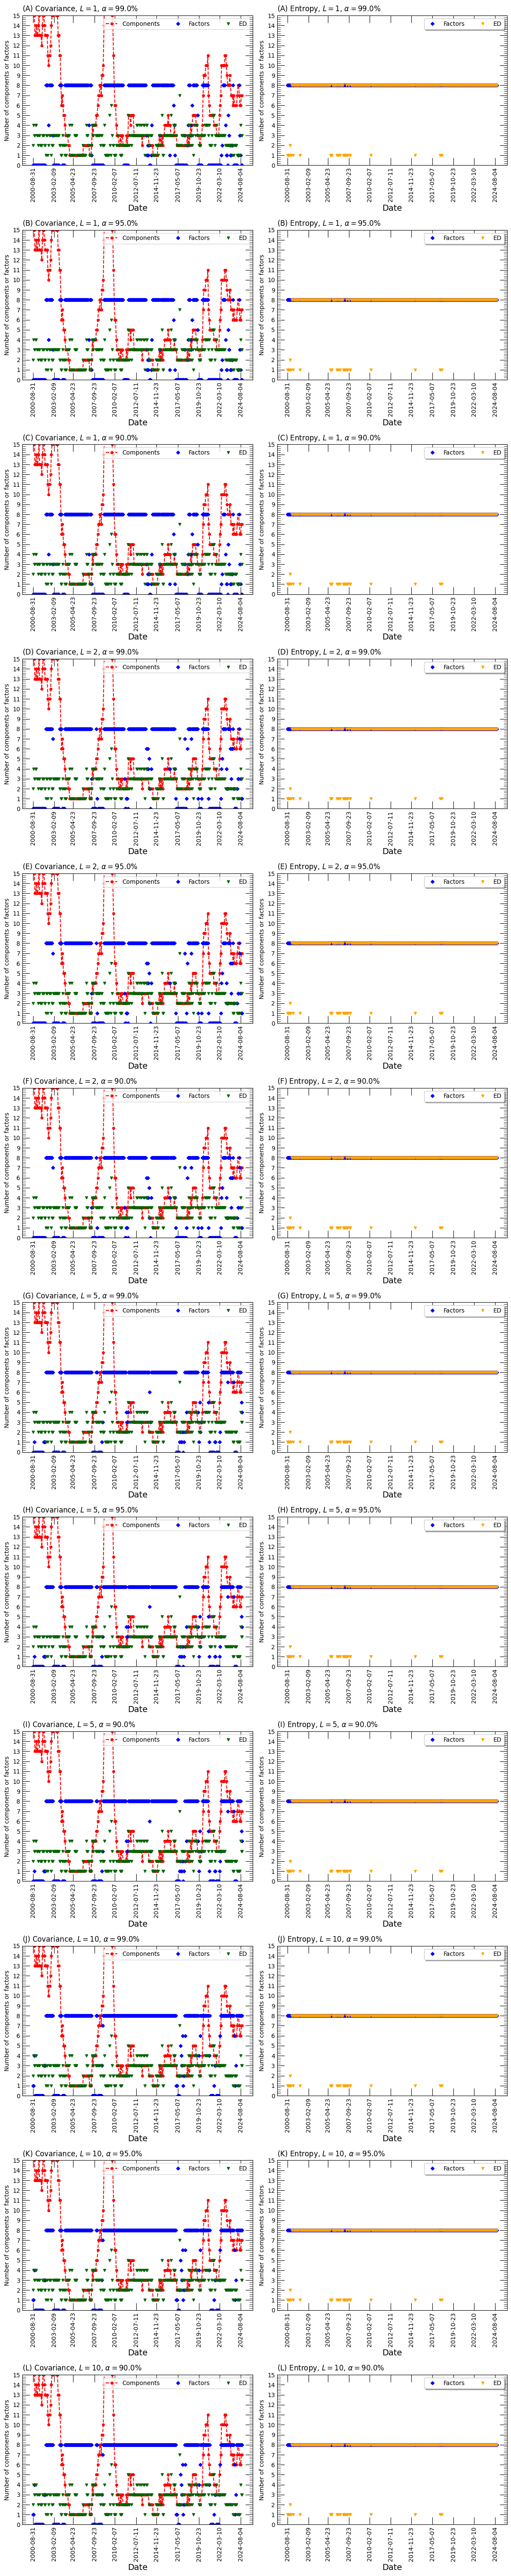

In [8]:
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as mtick # type: ignore

levels_ = df_final_3["level"].unique()
alphas_ = df_final_3["alpha"].unique()

fig,ax = plt.subplots(len(levels_) * len(alphas_), 2)
fig.set_size_inches(w = 12, h = 60)
ms = 4

for i in range(len(levels_)):
    for j in range(len(alphas_)):
        df_aux = df_final_3[((df_final_3["level"] == levels_[i]) & (df_final_3["alpha"] == alphas_[j]))]

        time_labels = pd.date_range(
            start = df_aux["final_date"].min(),
            end = df_aux["final_date"].max(),
            periods = 20
        ).strftime("%Y-%m-%d")

        # Components
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["n_components_cov"], color = "red", marker = "o", linestyle = "--", markersize = ms, label = "Components")
        #ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["n_components_entropy"], color = "red", marker = "o", linestyle = "--", markersize = ms, label = "Components")
        # Factors
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["n_factors_cov"], color = "blue", marker = "D", linestyle = "", markersize = ms, label = "Factors")
        ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["n_factors_entropy"], color = "blue", marker = "D", linestyle = "", markersize = ms, label = "Factors")
        # Edge Distribution
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["edge_distribution_cov"], color = "darkgreen", marker = "v", linestyle = "", markersize = ms, label = "ED")
        ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["edge_distribution_entropy"], color = "orange", marker = "v", linestyle = "", markersize = ms, label = "ED")
        # Axis formatter
        ax[j + i * len(alphas_), 0].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 10, length = 12)
        ax[j + i * len(alphas_), 0].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 10, length = 6)
        ax[j + i * len(alphas_), 0].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks = 100))
        ax[j + i * len(alphas_), 0].xaxis.set_minor_locator(mdates.AutoDateLocator(maxticks = 200))
        ax[j + i * len(alphas_), 0].yaxis.set_major_locator(mtick.MaxNLocator(15))
        ax[j + i * len(alphas_), 0].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 15))
        ax[j + i * len(alphas_), 0].set_xlabel("Date", fontsize = 14)        
        ax[j + i * len(alphas_), 0].set_ylabel("Number of components or factors", fontsize = 10)
        ax[j + i * len(alphas_), 0].tick_params(axis = "x", labelrotation = 90)
        ax[j + i * len(alphas_), 0].set_ylim(0,15) #bbox_to_anchor=(1.1, 1.05)
        ax[j + i * len(alphas_), 0].legend(fancybox = True, shadow = False, ncol = 3, fontsize = 10)
        ax[j + i * len(alphas_), 0].set_title(
            r"({}) Covariance, $L={}$, $\alpha={}\%$".format(chr(j + i * len(alphas_) + 65), levels_[i], (1 - alphas_[j]) * 100),
            loc = "left",
            y = 1.005,
            fontsize = 12
        )

        ax[j + i * len(alphas_), 1].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 10, length = 12)
        ax[j + i * len(alphas_), 1].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 10, length = 6)
        ax[j + i * len(alphas_), 1].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks = 100))
        ax[j + i * len(alphas_), 1].xaxis.set_minor_locator(mdates.AutoDateLocator(maxticks = 200))
        ax[j + i * len(alphas_), 1].yaxis.set_major_locator(mtick.MaxNLocator(15))
        ax[j + i * len(alphas_), 1].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 15))
        ax[j + i * len(alphas_), 1].set_xlabel("Date", fontsize = 14)        
        ax[j + i * len(alphas_), 1].set_ylabel("Number of components or factors", fontsize = 10)
        ax[j + i * len(alphas_), 1].tick_params(axis = "x", labelrotation = 90)
        ax[j + i * len(alphas_), 1].set_ylim(0,15) #bbox_to_anchor=(1.1, 1.05)
        ax[j + i * len(alphas_), 1].legend(fancybox = True, shadow = True, ncol = 3, fontsize = 10)
        ax[j + i * len(alphas_), 1].set_title(
            r"({}) Entropy, $L={}$, $\alpha={}\%$".format(chr(j + i * len(alphas_)+ 65), levels_[i], (1 - alphas_[j]) * 100),
            loc = "left",
            y = 1.005,
            fontsize = 12
        )

plt.tight_layout()
plt.show()

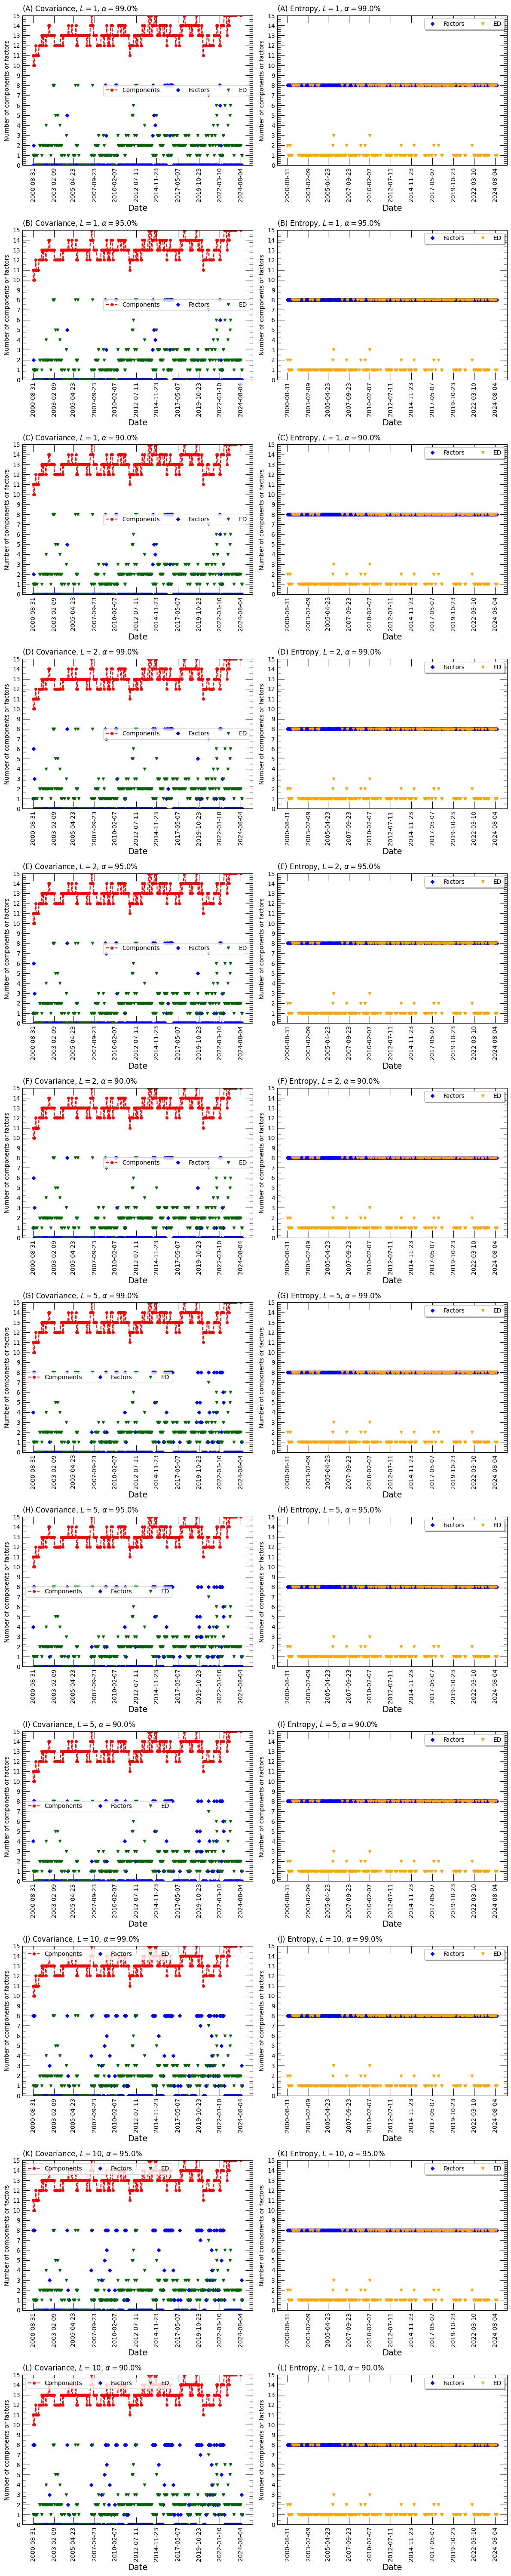

In [9]:
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as mtick # type: ignore

levels_ = df_final_4["level"].unique()
alphas_ = df_final_4["alpha"].unique()

fig,ax = plt.subplots(len(levels_) * len(alphas_), 2)
fig.set_size_inches(w = 12, h = 60)
ms = 4

for i in range(len(levels_)):
    for j in range(len(alphas_)):
        df_aux = df_final_4[((df_final_4["level"] == levels_[i]) & (df_final_4["alpha"] == alphas_[j]))]

        time_labels = pd.date_range(
            start = df_aux["final_date"].min(),
            end = df_aux["final_date"].max(),
            periods = 20
        ).strftime("%Y-%m-%d")

        # Components
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["n_components_cov"], color = "red", marker = "o", linestyle = "--", markersize = ms, label = "Components")
        #ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["n_components_entropy"], color = "red", marker = "o", linestyle = "--", markersize = ms, label = "Components")
        # Factors
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["n_factors_cov"], color = "blue", marker = "D", linestyle = "", markersize = ms, label = "Factors")
        ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["n_factors_entropy"], color = "blue", marker = "D", linestyle = "", markersize = ms, label = "Factors")
        # Edge Distribution
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["edge_distribution_cov"], color = "darkgreen", marker = "v", linestyle = "", markersize = ms, label = "ED")
        ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["edge_distribution_entropy"], color = "orange", marker = "v", linestyle = "", markersize = ms, label = "ED")
        # Axis formatter
        ax[j + i * len(alphas_), 0].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 10, length = 12)
        ax[j + i * len(alphas_), 0].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 10, length = 6)
        ax[j + i * len(alphas_), 0].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks = 100))
        ax[j + i * len(alphas_), 0].xaxis.set_minor_locator(mdates.AutoDateLocator(maxticks = 200))
        ax[j + i * len(alphas_), 0].yaxis.set_major_locator(mtick.MaxNLocator(15))
        ax[j + i * len(alphas_), 0].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 15))
        ax[j + i * len(alphas_), 0].set_xlabel("Date", fontsize = 14)        
        ax[j + i * len(alphas_), 0].set_ylabel("Number of components or factors", fontsize = 10)
        ax[j + i * len(alphas_), 0].tick_params(axis = "x", labelrotation = 90)
        ax[j + i * len(alphas_), 0].set_ylim(0,15) #bbox_to_anchor=(1.1, 1.05)
        ax[j + i * len(alphas_), 0].legend(fancybox = True, shadow = False, ncol = 3, fontsize = 10)
        ax[j + i * len(alphas_), 0].set_title(
            r"({}) Covariance, $L={}$, $\alpha={}\%$".format(chr(j + i * len(alphas_) + 65), levels_[i], (1 - alphas_[j]) * 100),
            loc = "left",
            y = 1.005,
            fontsize = 12
        )

        ax[j + i * len(alphas_), 1].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 10, length = 12)
        ax[j + i * len(alphas_), 1].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 10, length = 6)
        ax[j + i * len(alphas_), 1].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks = 100))
        ax[j + i * len(alphas_), 1].xaxis.set_minor_locator(mdates.AutoDateLocator(maxticks = 200))
        ax[j + i * len(alphas_), 1].yaxis.set_major_locator(mtick.MaxNLocator(15))
        ax[j + i * len(alphas_), 1].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 15))
        ax[j + i * len(alphas_), 1].set_xlabel("Date", fontsize = 14)        
        ax[j + i * len(alphas_), 1].set_ylabel("Number of components or factors", fontsize = 10)
        ax[j + i * len(alphas_), 1].tick_params(axis = "x", labelrotation = 90)
        ax[j + i * len(alphas_), 1].set_ylim(0,15) #bbox_to_anchor=(1.1, 1.05)
        ax[j + i * len(alphas_), 1].legend(fancybox = True, shadow = True, ncol = 3, fontsize = 10)
        ax[j + i * len(alphas_), 1].set_title(
            r"({}) Entropy, $L={}$, $\alpha={}\%$".format(chr(j + i * len(alphas_) + 65), levels_[i], (1 - alphas_[j]) * 100),
            loc = "left",
            y = 1.005,
            fontsize = 12
        )

plt.tight_layout()
plt.show()